## Setup

In [1]:
from OPMD_acq.testbench_funcs import OPMD_TestBench, pm_modes
from bench.bench import tb 

In [2]:
from time import sleep
import numpy as np
import pickle as pkl
import matplotlib.pyplot as plt
from pylab import rcParams
rcParams['figure.figsize'] = 12, 8

### Slow Source

In [10]:
# tb.start_lamp()
tb.stop_lamp()
# tb.wavelength = 600 
# print(tb.wavelength)
# tb.get_lamp_current()
# tb.set_lamp_current(10.0)
# with tb.lamp_power_context(stoponsuccess=True) as session: 
#     pass 

In [16]:
# tb.stop_lamp()
tb.get_lamp_current()

0.0

### Power Meter

In [5]:
# tb.setup_photodiode(pm_modes.SINGLESHOT_MANUAL, 1)
# tb.photodiode_units = 'A'
# print(tb.photodiode_units)
# tb.measure_photodiode(1)
# tb.measure_light_current_instantaneous(1)
# tb.get_photodiode_responsivity(1)

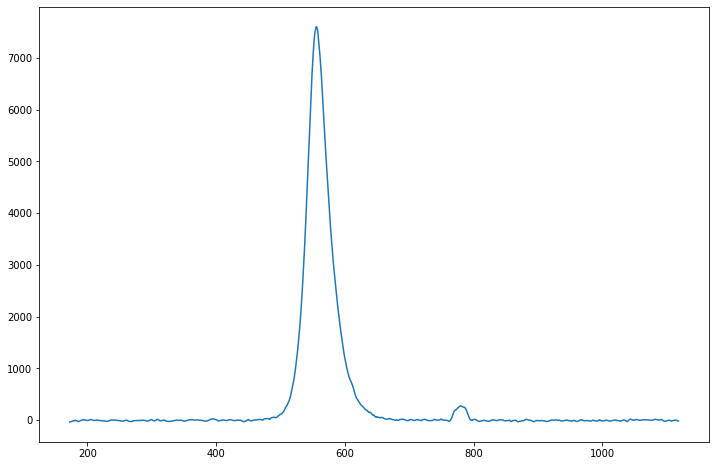

In [8]:
tb.wavelength = 780 
specwl, spec = tb.read_smooth_spectrum(20)
plt.plot(specwl, spec)

### Spectrometer

In [6]:
# tb.read_spectrum(100)

### Parameter

In [7]:
# wls = [460, 480, 500, 520, 540, 560, 580, 600, 620, 640, 660, 680, 700]
# exposure = 300
# trials = 400

## 1. Powermeter

In [ ]:
from calibration.powermeter import run_powermeter
wls = [500, 520]
trials = 400
pause = 0
run_powermeter(wls, trials, pause)

Setting the wavelength of the slow source to: 500.00


## 2. Spectrometer

In [8]:
tb.wavelength = 650

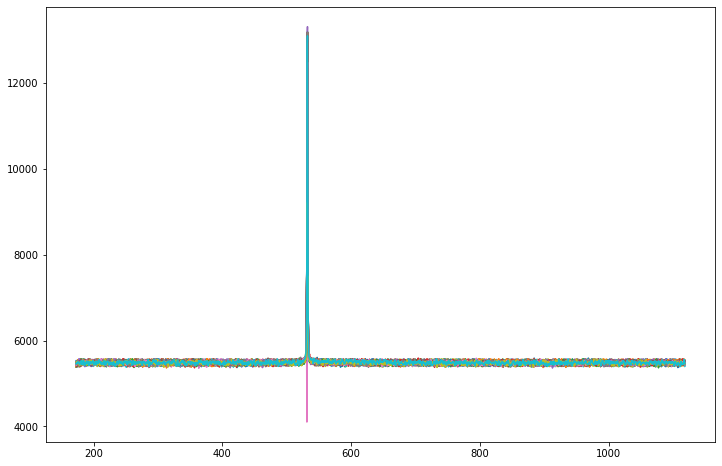

In [9]:
from tqdm import tqdm_notebook
wls, specs = [], []
fig1, ax1 = plt.subplots()
for i in tqdm_notebook(range(50)):
    wl, spec = tb.read_spectrum(30)
    wls.append(wl)
    specs.append(spec)
    ax1.plot(wl, spec)

In [10]:
# from tqdm import tqdm_notebook
# wls, specs = [], []
# fig1, ax1 = plt.subplots()
# fig2, ax2 = plt.subplots()
# fig3, ax3 = plt.subplots()
# fig4, ax4 = plt.subplots()
# for i in tqdm_notebook(range(50)):
#     wl, spec, base_filter_spec, out_filter_wls, out_filter_spec, specwl_, spec_ = tb.read_smooth_spectrum(20)
#     ax1.plot(wl, spec)
#     ax2.plot(wl, base_filter_spec)
#     ax3.plot(out_filter_wls, out_filter_spec)
#     ax4.plot(specwl_, spec_)

In [11]:
# ax1.set_xlim(520, 540)
# ax2.set_xlim(520, 540)
# ax3.set_xlim(520, 540)
# ax4.set_xlim(520, 540)

In [12]:
def maxDiff(array): 
    return np.max(array) - np.min(array)

In [13]:
def local_varation(base_filter_spec, win_len): 
    local_variations = []
    for i in range(len(base_filter_spec)): 
        if i - win_len >= 0 and i + win_len <= 2047: 
            local_max = maxDiff(base_filter_spec[i - win_len: i + win_len + 1])
        elif i - win_len <= 0 and i + win_len <= 2047: 
            local_max = maxDiff(base_filter_spec[0: i + win_len + 1])
        elif i - win_len >= 0 and i + win_len >= 2047: 
            local_max = maxDiff(base_filter_spec[i - win_len: 2047])
        else: 
            local_max = maxDiff(base_filter_spec[0: 2047])
        local_variations.append(local_max)
    return local_variations

In [14]:
def read_smooth_spectrum(wls, spec, darkframe=None):

    spec_dict = dict(collections.Counter(spec))
    spec_count, spec_sum = 0, 0
    for s in spec_dict.keys():
        if spec_dict[s] > 10:
            spec_count += spec_dict[s]
            spec_sum += s*spec_dict[s]
    base_filter = spec_sum / spec_count
    base_filter_spec = np.array(spec) - base_filter

    # remove outlier
    win_len = 6
    local_variations = local_varation(base_filter_spec, win_len-2)
    out_filter = medfilt(base_filter_spec, win_len*2+1)
    out_filter_index = abs(np.array(base_filter_spec) - out_filter) < np.array(local_variations)*0.7
    out_filter_wls = np.array(wls)[out_filter_index]
    out_filter_spec = np.array(base_filter_spec)[out_filter_index]

    # interpolate & smooth
    interp = interp1d(out_filter_wls, out_filter_spec, kind='quadratic')
    window_size, poly_order = 101, 3
    specwl_ = np.linspace(out_filter_wls[0], out_filter_wls[-1], len(wls)*4)
    spec_ = savgol_filter(interp(specwl_), window_size, poly_order, mode='nearest')

    return base_filter_spec, out_filter_wls, out_filter_spec, specwl_, spec_

In [15]:
import collections
import pickle
import matplotlib.pyplot as plt
from pylab import rcParams
rcParams['figure.figsize'] = 12, 8
import numpy as np
from scipy.signal import savgol_filter, medfilt
from scipy.interpolate import interp1d

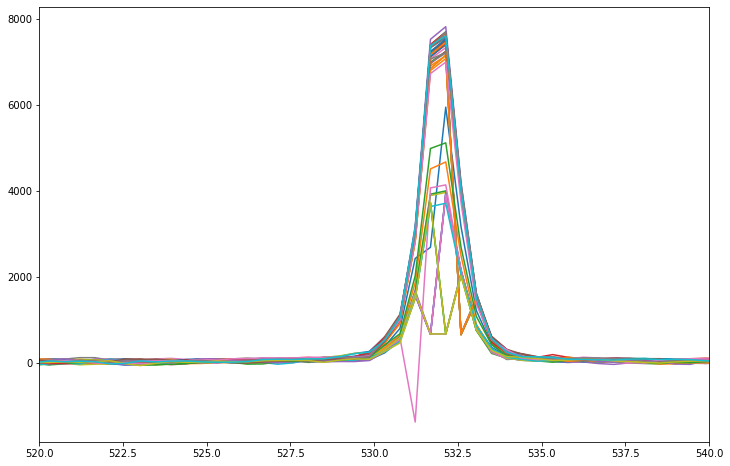

In [16]:
for i in range(len(wls)): 
    base_filter_spec, out_filter_wls, out_filter_spec, specwl_, spec_ = read_smooth_spectrum(wls[i], specs[i], darkframe=None)
    plt.plot(wls[29], base_filter_spec)
    plt.xlim(520, 540)


IndexError: boolean index did not match indexed array along dimension 0; dimension is 50 but corresponding boolean dimension is 2048

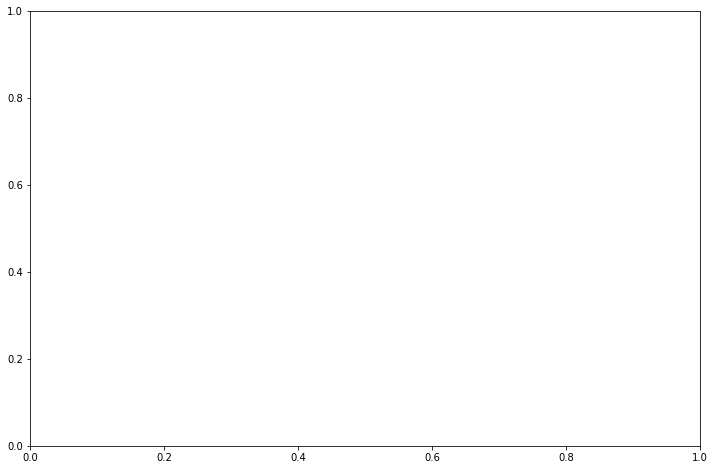

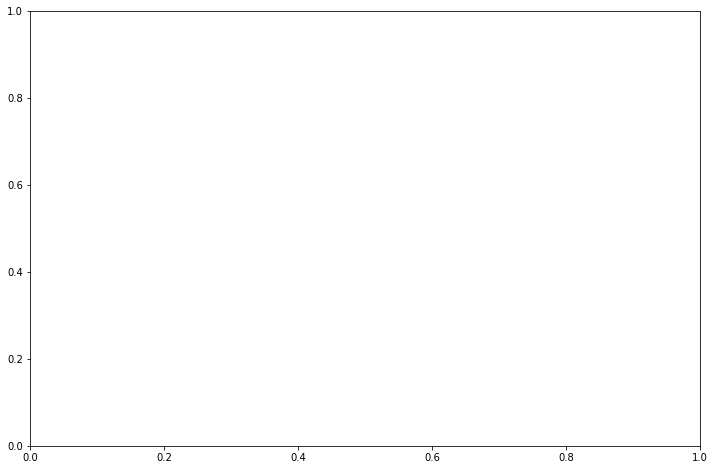

In [27]:
fig1, ax1 = plt.subplots()
fig2, ax2 = plt.subplots()
for i in range(np.shape(spec)[0]): 
    base_filter_spec, out_filter_wls, out_filter_spec, specwl_, spec_ = read_smooth_spectrum(wls, specs[i], darkframe=None)
    ax1.plot(wl, base_filter_spec)
    ax2.plot(out_filter_wls, out_filter_spec)
    ax1.set_xlim(500, 560)
    ax2.set_xlim(500, 560)
    

In [59]:
# from calibration.spectrometer import run_spectrometer
# wls = [460, 480]
# trials = 100
# pause = 0
# exposure = 300

# run_spectrometer(wls, trials, pause, exposure)

## 3. Time Series

In [ ]:
import pickle
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from pmdarima.arima import auto_arima
import seaborn as sns
sns.set()
trials = 400

with open('/Users/mingyu/Desktop/OPMD_Mingyu/results/calibration/powermeter/experiment_2/20200219-091938_wl-520.pkl', 'rb') as handle:
    content = pickle.load(handle)

df = pd.DataFrame({'Measured_Power': content['measured_power_trials'][:30], 
                   'Ambient_Power': content['ambient_power_trials'][:30], 
                   'Second': content['second_trials'][:30]})

model = auto_arima(np.diff(content['measured_power_trials']), start_p=1, start_q=1, max_p=5, max_q=5, 
                   seasonal=False, stepwise=True, suppress_warnings=True)


In [ ]:
plot_pacf(np.diff(content['measured_power_trials']), lags=50)
plt.show()

In [ ]:
plot_acf(np.diff(content['measured_power_trials']), lags=50)
plt.show()

## 2. Spectral Intensity 

- Find the output intensity as a function of central wavelength
- Find the bias vs. variance trade off

In [7]:
repeat = 50 

In [8]:
trials = 20 
pause = 0
run_measure_intensities(trials, pause, wls, exposure, repeat)

NameError: name 'run_measure_intensities' is not defined

## 2. Experiment: Spectral Profile

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from calibration.monochromator import intensity_density, intensity_integral

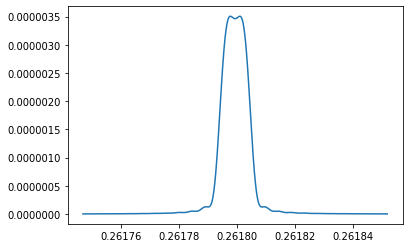

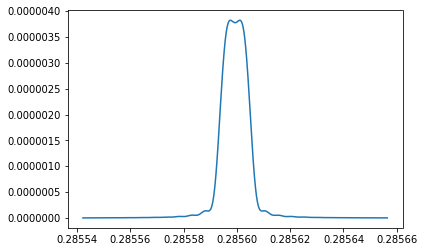

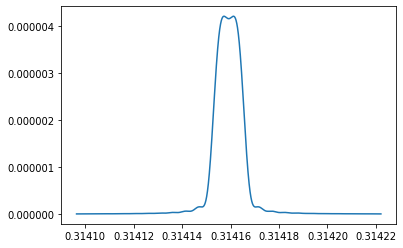

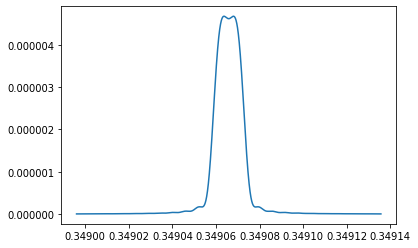

In [2]:
lambda_over_d_central_all = [np.pi/12, np.pi/11, np.pi/10, np.pi/9]
slit_width = 0.00002
for lambda_over_d_central in lambda_over_d_central_all:
    lambda_over_d_all, integral_all = intensity_integral(slit_width, lambda_over_d_central)
    plt.plot(lambda_over_d_all, integral_all)
    plt.show()

In [22]:
theta = np.linspace(-np.pi, np.pi, 1000000)
intensity_list = []
for i in theta: 
    intensity = intensity_density(i, np.pi/6)
    intensity_list.append(intensity)
plt.figure(figsize = (12, 8))
plt.plot(theta, intensity_list)

In [2]:
from calibration.stability import run_test_spectrometer

/Users/mingyu/Desktop/OPMD_acq/OPMD_acq/testbench_funcs.py:97: UserWarning: no Archon connected to server, CCD functionality will be disabled...
  warn("no Archon connected to server, CCD functionality will be disabled...")



Current Time 2020-02-05 14:35:37.018550 Working on trial 0
Getting spectrum and power for wavelength: 600.00

Current Time 2020-02-05 14:35:38.702703 Working on trial 1
Getting spectrum and power for wavelength: 600.00

Current Time 2020-02-05 14:35:40.457344 Working on trial 2
Getting spectrum and power for wavelength: 600.00

Current Time 2020-02-05 14:35:42.081525 Working on trial 3
Getting spectrum and power for wavelength: 600.00

Current Time 2020-02-05 14:35:43.788089 Working on trial 4
Getting spectrum and power for wavelength: 600.00

Current Time 2020-02-05 14:35:45.459361 Working on trial 5
Getting spectrum and power for wavelength: 600.00

Current Time 2020-02-05 14:35:47.305321 Working on trial 6
Getting spectrum and power for wavelength: 600.00

Current Time 2020-02-05 14:35:49.124214 Working on trial 7
Getting spectrum and power for wavelength: 600.00

Current Time 2020-02-05 14:35:50.857720 Working on trial 8
Getting spectrum and power for wavelength: 600.00

Current T


Current Time 2020-02-05 14:37:47.318182 Working on trial 74
Getting spectrum and power for wavelength: 600.00

Current Time 2020-02-05 14:37:49.184801 Working on trial 75
Getting spectrum and power for wavelength: 600.00

Current Time 2020-02-05 14:37:50.800426 Working on trial 76
Getting spectrum and power for wavelength: 600.00

Current Time 2020-02-05 14:37:52.637579 Working on trial 77
Getting spectrum and power for wavelength: 600.00

Current Time 2020-02-05 14:37:54.789706 Working on trial 78
Getting spectrum and power for wavelength: 600.00

Current Time 2020-02-05 14:37:56.837567 Working on trial 79
Getting spectrum and power for wavelength: 600.00

Current Time 2020-02-05 14:37:58.681157 Working on trial 80
Getting spectrum and power for wavelength: 600.00

Current Time 2020-02-05 14:38:00.423851 Working on trial 81
Getting spectrum and power for wavelength: 600.00

Current Time 2020-02-05 14:38:02.160954 Working on trial 82
Getting spectrum and power for wavelength: 600.00




Current Time 2020-02-05 14:40:04.669354 Working on trial 148
Getting spectrum and power for wavelength: 600.00

Current Time 2020-02-05 14:40:06.975758 Working on trial 149
Getting spectrum and power for wavelength: 600.00

Current Time 2020-02-05 14:40:09.316847 Working on trial 150
Getting spectrum and power for wavelength: 600.00

Current Time 2020-02-05 14:40:10.981120 Working on trial 151
Getting spectrum and power for wavelength: 600.00

Current Time 2020-02-05 14:40:12.732303 Working on trial 152
Getting spectrum and power for wavelength: 600.00

Current Time 2020-02-05 14:40:14.564026 Working on trial 153
Getting spectrum and power for wavelength: 600.00

Current Time 2020-02-05 14:40:16.307026 Working on trial 154
Getting spectrum and power for wavelength: 600.00

Current Time 2020-02-05 14:40:17.944091 Working on trial 155
Getting spectrum and power for wavelength: 600.00

Current Time 2020-02-05 14:40:19.783869 Working on trial 156
Getting spectrum and power for wavelength:


Current Time 2020-02-05 14:42:24.304916 Working on trial 222
Getting spectrum and power for wavelength: 600.00

Current Time 2020-02-05 14:42:26.455212 Working on trial 223
Getting spectrum and power for wavelength: 600.00

Current Time 2020-02-05 14:42:28.194702 Working on trial 224
Getting spectrum and power for wavelength: 600.00

Current Time 2020-02-05 14:42:30.038919 Working on trial 225
Getting spectrum and power for wavelength: 600.00

Current Time 2020-02-05 14:42:31.880713 Working on trial 226
Getting spectrum and power for wavelength: 600.00

Current Time 2020-02-05 14:42:33.930963 Working on trial 227
Getting spectrum and power for wavelength: 600.00

Current Time 2020-02-05 14:42:35.812415 Working on trial 228
Getting spectrum and power for wavelength: 600.00

Current Time 2020-02-05 14:42:37.519613 Working on trial 229
Getting spectrum and power for wavelength: 600.00

Current Time 2020-02-05 14:42:39.629981 Working on trial 230
Getting spectrum and power for wavelength:


Current Time 2020-02-05 14:44:39.140354 Working on trial 296
Getting spectrum and power for wavelength: 600.00

Current Time 2020-02-05 14:44:41.211435 Working on trial 297
Getting spectrum and power for wavelength: 600.00

Current Time 2020-02-05 14:44:43.374725 Working on trial 298
Getting spectrum and power for wavelength: 600.00

Current Time 2020-02-05 14:44:45.217845 Working on trial 299
Getting spectrum and power for wavelength: 600.00

Current Time 2020-02-05 14:44:47.160246 Working on trial 300
Getting spectrum and power for wavelength: 600.00

Current Time 2020-02-05 14:44:49.244168 Working on trial 301
Getting spectrum and power for wavelength: 600.00

Current Time 2020-02-05 14:44:50.949763 Working on trial 302
Getting spectrum and power for wavelength: 600.00

Current Time 2020-02-05 14:44:52.606594 Working on trial 303
Getting spectrum and power for wavelength: 600.00

Current Time 2020-02-05 14:44:54.728588 Working on trial 304
Getting spectrum and power for wavelength:


Current Time 2020-02-05 14:47:04.469230 Working on trial 370
Getting spectrum and power for wavelength: 600.00

Current Time 2020-02-05 14:47:06.716811 Working on trial 371
Getting spectrum and power for wavelength: 600.00

Current Time 2020-02-05 14:47:08.511404 Working on trial 372
Getting spectrum and power for wavelength: 600.00

Current Time 2020-02-05 14:47:10.197220 Working on trial 373
Getting spectrum and power for wavelength: 600.00

Current Time 2020-02-05 14:47:12.042895 Working on trial 374
Getting spectrum and power for wavelength: 600.00

Current Time 2020-02-05 14:47:13.894255 Working on trial 375
Getting spectrum and power for wavelength: 600.00

Current Time 2020-02-05 14:47:15.640017 Working on trial 376
Getting spectrum and power for wavelength: 600.00

Current Time 2020-02-05 14:47:18.932812 Working on trial 377
Getting spectrum and power for wavelength: 600.00

Current Time 2020-02-05 14:47:21.369609 Working on trial 378
Getting spectrum and power for wavelength:


Current Time 2020-02-05 14:49:28.746686 Working on trial 444
Getting spectrum and power for wavelength: 600.00

Current Time 2020-02-05 14:49:30.487228 Working on trial 445
Getting spectrum and power for wavelength: 600.00

Current Time 2020-02-05 14:49:32.328842 Working on trial 446
Getting spectrum and power for wavelength: 600.00

Current Time 2020-02-05 14:49:34.170468 Working on trial 447
Getting spectrum and power for wavelength: 600.00

Current Time 2020-02-05 14:49:35.783771 Working on trial 448
Getting spectrum and power for wavelength: 600.00

Current Time 2020-02-05 14:49:37.450342 Working on trial 449
Getting spectrum and power for wavelength: 600.00

Current Time 2020-02-05 14:49:39.188671 Working on trial 450
Getting spectrum and power for wavelength: 600.00

Current Time 2020-02-05 14:49:40.921209 Working on trial 451
Getting spectrum and power for wavelength: 600.00

Current Time 2020-02-05 14:49:42.574914 Working on trial 452
Getting spectrum and power for wavelength:


Current Time 2020-02-05 14:51:38.172706 Working on trial 518
Getting spectrum and power for wavelength: 600.00

Current Time 2020-02-05 14:51:39.977768 Working on trial 519
Getting spectrum and power for wavelength: 600.00

Current Time 2020-02-05 14:51:41.552250 Working on trial 520
Getting spectrum and power for wavelength: 600.00

Current Time 2020-02-05 14:51:43.266777 Working on trial 521
Getting spectrum and power for wavelength: 600.00

Current Time 2020-02-05 14:51:44.931481 Working on trial 522
Getting spectrum and power for wavelength: 600.00

Current Time 2020-02-05 14:51:46.466446 Working on trial 523
Getting spectrum and power for wavelength: 600.00

Current Time 2020-02-05 14:51:48.313782 Working on trial 524
Getting spectrum and power for wavelength: 600.00

Current Time 2020-02-05 14:51:49.781073 Working on trial 525
Getting spectrum and power for wavelength: 600.00

Current Time 2020-02-05 14:51:51.904782 Working on trial 526
Getting spectrum and power for wavelength:


Current Time 2020-02-05 14:53:49.140824 Working on trial 592
Getting spectrum and power for wavelength: 600.00

Current Time 2020-02-05 14:53:50.782026 Working on trial 593
Getting spectrum and power for wavelength: 600.00

Current Time 2020-02-05 14:53:52.521525 Working on trial 594
Getting spectrum and power for wavelength: 600.00

Current Time 2020-02-05 14:53:54.230078 Working on trial 595
Getting spectrum and power for wavelength: 600.00

Current Time 2020-02-05 14:53:56.005669 Working on trial 596
Getting spectrum and power for wavelength: 600.00

Current Time 2020-02-05 14:53:57.747822 Working on trial 597
Getting spectrum and power for wavelength: 600.00

Current Time 2020-02-05 14:53:59.551656 Working on trial 598
Getting spectrum and power for wavelength: 600.00

Current Time 2020-02-05 14:54:01.226000 Working on trial 599
Getting spectrum and power for wavelength: 600.00

Current Time 2020-02-05 14:54:03.068589 Working on trial 600
Getting spectrum and power for wavelength:


Current Time 2020-02-05 14:55:59.493143 Working on trial 666
Getting spectrum and power for wavelength: 600.00

Current Time 2020-02-05 14:56:01.236941 Working on trial 667
Getting spectrum and power for wavelength: 600.00

Current Time 2020-02-05 14:56:02.943744 Working on trial 668
Getting spectrum and power for wavelength: 600.00

Current Time 2020-02-05 14:56:04.587489 Working on trial 669
Getting spectrum and power for wavelength: 600.00

Current Time 2020-02-05 14:56:06.149351 Working on trial 670
Getting spectrum and power for wavelength: 600.00

Current Time 2020-02-05 14:56:07.790226 Working on trial 671
Getting spectrum and power for wavelength: 600.00

Current Time 2020-02-05 14:56:09.632718 Working on trial 672
Getting spectrum and power for wavelength: 600.00

Current Time 2020-02-05 14:56:11.155798 Working on trial 673
Getting spectrum and power for wavelength: 600.00

Current Time 2020-02-05 14:56:13.013279 Working on trial 674
Getting spectrum and power for wavelength:


Current Time 2020-02-05 14:58:06.768183 Working on trial 740
Getting spectrum and power for wavelength: 600.00

Current Time 2020-02-05 14:58:08.271562 Working on trial 741
Getting spectrum and power for wavelength: 600.00

Current Time 2020-02-05 14:58:10.259424 Working on trial 742
Getting spectrum and power for wavelength: 600.00

Current Time 2020-02-05 14:58:12.103264 Working on trial 743
Getting spectrum and power for wavelength: 600.00

Current Time 2020-02-05 14:58:13.844076 Working on trial 744
Getting spectrum and power for wavelength: 600.00

Current Time 2020-02-05 14:58:15.584061 Working on trial 745
Getting spectrum and power for wavelength: 600.00

Current Time 2020-02-05 14:58:17.325389 Working on trial 746
Getting spectrum and power for wavelength: 600.00

Current Time 2020-02-05 14:58:19.237379 Working on trial 747
Getting spectrum and power for wavelength: 600.00

Current Time 2020-02-05 14:58:20.882444 Working on trial 748
Getting spectrum and power for wavelength:


Current Time 2020-02-05 15:00:14.978309 Working on trial 814
Getting spectrum and power for wavelength: 600.00

Current Time 2020-02-05 15:00:16.890945 Working on trial 815
Getting spectrum and power for wavelength: 600.00

Current Time 2020-02-05 15:00:18.769013 Working on trial 816
Getting spectrum and power for wavelength: 600.00

Current Time 2020-02-05 15:00:20.511071 Working on trial 817
Getting spectrum and power for wavelength: 600.00

Current Time 2020-02-05 15:00:22.147646 Working on trial 818
Getting spectrum and power for wavelength: 600.00

Current Time 2020-02-05 15:00:23.989167 Working on trial 819
Getting spectrum and power for wavelength: 600.00

Current Time 2020-02-05 15:00:25.629051 Working on trial 820
Getting spectrum and power for wavelength: 600.00

Current Time 2020-02-05 15:00:27.469449 Working on trial 821
Getting spectrum and power for wavelength: 600.00

Current Time 2020-02-05 15:00:29.224207 Working on trial 822
Getting spectrum and power for wavelength:


Current Time 2020-02-05 15:02:19.495829 Working on trial 888
Getting spectrum and power for wavelength: 600.00

Current Time 2020-02-05 15:02:21.021118 Working on trial 889
Getting spectrum and power for wavelength: 600.00

Current Time 2020-02-05 15:02:22.495477 Working on trial 890
Getting spectrum and power for wavelength: 600.00

Current Time 2020-02-05 15:02:23.973764 Working on trial 891
Getting spectrum and power for wavelength: 600.00

Current Time 2020-02-05 15:02:25.541581 Working on trial 892
Getting spectrum and power for wavelength: 600.00

Current Time 2020-02-05 15:02:27.188323 Working on trial 893
Getting spectrum and power for wavelength: 600.00

Current Time 2020-02-05 15:02:28.818397 Working on trial 894
Getting spectrum and power for wavelength: 600.00

Current Time 2020-02-05 15:02:30.350557 Working on trial 895
Getting spectrum and power for wavelength: 600.00

Current Time 2020-02-05 15:02:32.384019 Working on trial 896
Getting spectrum and power for wavelength:


Current Time 2020-02-05 15:04:24.321483 Working on trial 962
Getting spectrum and power for wavelength: 600.00

Current Time 2020-02-05 15:04:26.164767 Working on trial 963
Getting spectrum and power for wavelength: 600.00

Current Time 2020-02-05 15:04:27.902911 Working on trial 964
Getting spectrum and power for wavelength: 600.00

Current Time 2020-02-05 15:04:29.745542 Working on trial 965
Getting spectrum and power for wavelength: 600.00

Current Time 2020-02-05 15:04:31.793679 Working on trial 966
Getting spectrum and power for wavelength: 600.00

Current Time 2020-02-05 15:04:33.355312 Working on trial 967
Getting spectrum and power for wavelength: 600.00

Current Time 2020-02-05 15:04:34.885053 Working on trial 968
Getting spectrum and power for wavelength: 600.00

Current Time 2020-02-05 15:04:36.356615 Working on trial 969
Getting spectrum and power for wavelength: 600.00

Current Time 2020-02-05 15:04:37.852370 Working on trial 970
Getting spectrum and power for wavelength:

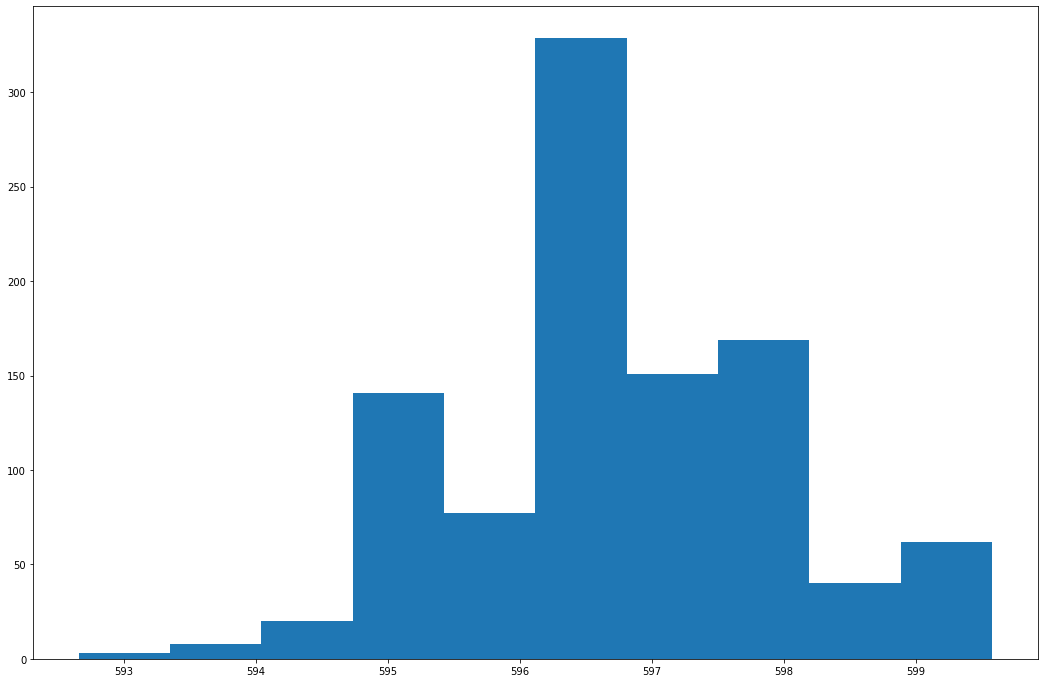

In [4]:
trials = 1000
wls = [600]
exposure = 300
repeat = 1
central_wl_trials, fig = run_test_spectrometer(trials, wls, exposure, repeat)

- The integral doesn't converge -> use a small value in denomenator 
- The linspace is not fine enough 

In [1]:
import matplotlib.pyplot as plt
from experiment.experiment import tb
from scipy.signal import medfilt
import numpy as np
from scipy.signal import butter
from scipy.signal import filtfilt
# wls, spec, spec_s = tb.read_smooth_spectrum(300)
# tb.set_lamp_current(10.0)
# print(tb.get_lamp_current())
wls, spec, base_filter_spec, wls_, spec_ = tb.read_smooth_spectrum(300)


/Users/mingyu/Desktop/OPMD_acq/OPMD_acq/testbench_funcs.py:99: UserWarning: no Archon connected to server, CCD functionality will be disabled...
  warn("no Archon connected to server, CCD functionality will be disabled...")


164.02680455030102


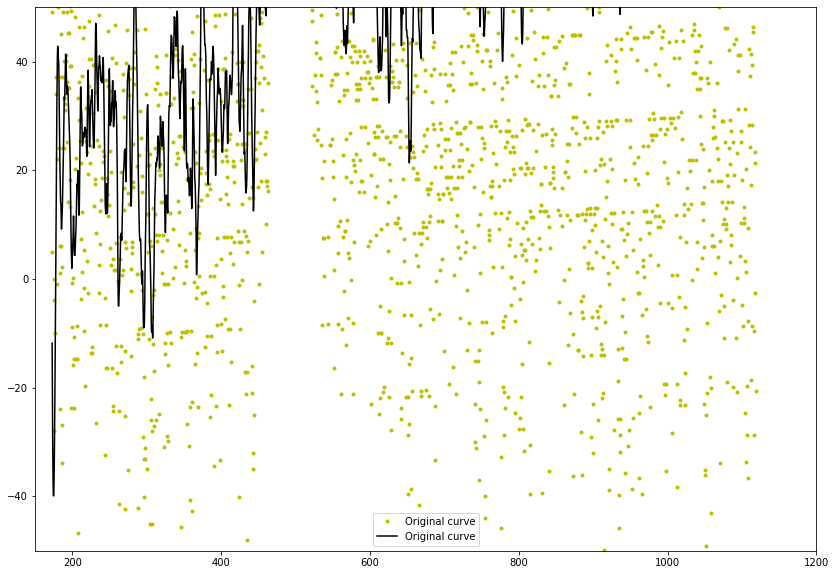

In [4]:
fig = plt.figure(figsize=(14, 10))

plt.plot(wls, spec-baseline, 'y.', label= 'Original curve')
plt.plot(wls_, spec_, 'k-', label= 'Original curve')
plt.legend(loc='best')
# plt.xlim(150, 1200)
# plt.ylim(-50, 50)
plt.legend(loc='best')

In [1]:
from calibration.spec_correction import *

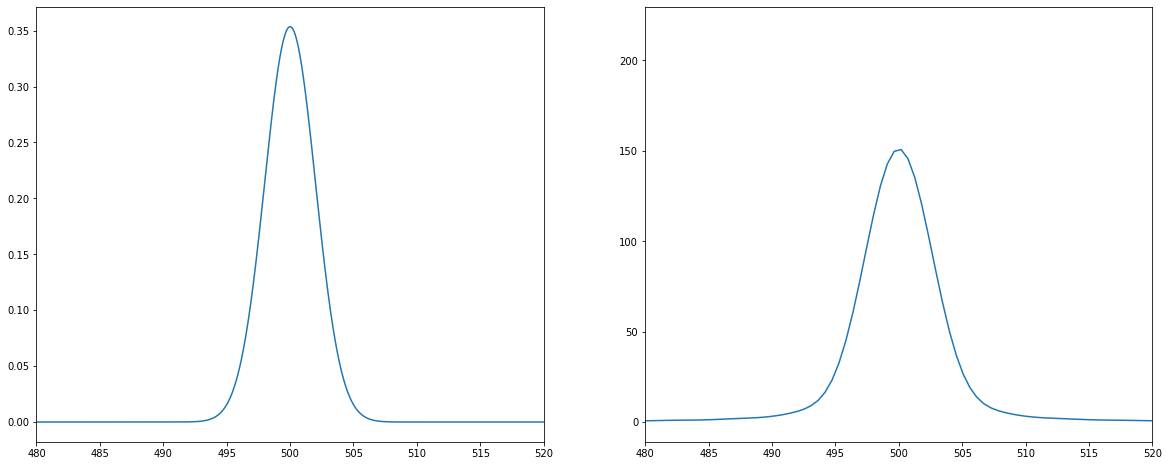

In [2]:
wl, mean, std = np.linspace(480, 520, 5000), 500, 2
theta = np.linspace(-np.pi / 2, np.pi / 2, 5000)

I = gaussian_intensity(wl, mean, std)
interference_Is = []
for t in theta:
    interference_I = sum(kernel(t, wl) * I)
    interference_Is.append(interference_I)

fig, axes = plt.subplots(1, 2, figsize=(20, 8))
axes[0].plot(wl, I)
axes[0].set_xlim(480, 520)
axes[1].plot(np.sin(theta)*D, interference_Is)
axes[1].set_xlim(480, 520)
plt.show(fig)

In [8]:
import numpy as np
np.random.choice(3, 100)

array([1, 2, 1, 2, 0, 1, 2, 2, 1, 2, 0, 1, 2, 0, 1, 2, 2, 2, 0, 0, 2, 1,
       0, 2, 1, 0, 0, 1, 1, 2, 2, 1, 0, 1, 0, 1, 0, 0, 2, 0, 0, 1, 1, 2,
       2, 1, 0, 1, 0, 2, 2, 1, 2, 1, 0, 0, 0, 0, 1, 1, 2, 0, 2, 0, 1, 1,
       2, 1, 0, 1, 0, 2, 1, 1, 1, 2, 0, 1, 1, 1, 1, 0, 2, 0, 2, 2, 0, 2,
       1, 0, 2, 1, 2, 2, 1, 2, 1, 0, 0, 2])

(10000, 61000)

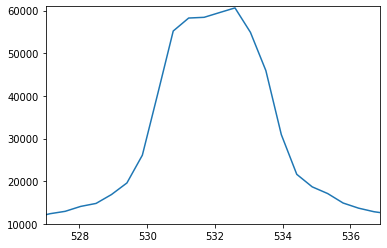

In [5]:
import pickle
import numpy as np
import matplotlib.pyplot as plt
with open('/Users/mingyu/Desktop/OPMD_Mingyu/random/20th_Feb/datas.pickle', 'rb') as handle: 
    specs = pickle.load(handle)
with open('/Users/mingyu/Desktop/OPMD_Mingyu/random/20th_Feb/wls.pickle', 'rb') as handle: 
    wls = pickle.load(handle)
spec = np.mean(specs, axis=0)

plt.plot(wls, spec)
plt.xlim(527.0, 536.89)
plt.ylim(10000, 61000)

(527.0383080632644, 536.8958155123631)

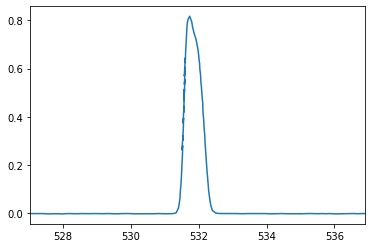

In [2]:
import pandas as pd 
import matplotlib.pyplot as plt
import numpy as np
content = pd.read_csv('/Users/mingyu/Desktop/Default_Dataset.csv', header=None)
wls, Is = content[0], content[1]
plt.plot(wls, Is)
plt.xlim(min(wls), max(wls))

(527.0383080632644, 536.8958155123631)

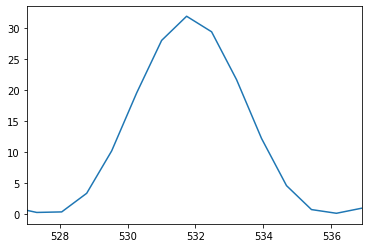

In [3]:
from tools.correction import convolution
thetaz = np.linspace(0, np.pi/2, 5000)
interference_Iz = convolution(Is, wls, thetaz)
plt.plot(np.sin(thetaz) * 1200, interference_Iz)
plt.xlim(min(wls), max(wls))

(527.0383080632644, 536.8958155123631)

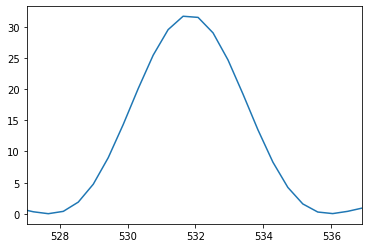

In [4]:
from tools.correction import convolution
thetaz = np.linspace(0, np.pi/2, 5000)
interference_Iz = convolution(Is, wls, thetaz)
plt.plot(np.sin(thetaz) * 1500, interference_Iz)
plt.xlim(min(wls), max(wls))

In [6]:
from bench.bench import measure_spectrometer

In [24]:
specwl, spec = measure_spectrometer(20, 1)

In [25]:
import numpy as np
specwl[np.argmax(spec)]

556.0393945716554

In [40]:
a = np.array([[]])
b = np.array([[1, 2]])
c = np.array([[1, 2]])

In [43]:
d = np.concatenate([a, b, c], axis=0)

ValueError: all the input array dimensions for the concatenation axis must match exactly, but along dimension 1, the array at index 0 has size 0 and the array at index 1 has size 2

In [42]:
d

array([[1., 2., 1., 2.]])